In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow_decision_forests as tfdf
import tensorflow as tf

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        pass
#        print(f"Directory: {root}")
#        for file in files:
#            print(f"  File: {file}")

list_directory_tree_with_os_walk('/kaggle/input/training-data')

In [3]:
starting_directory = '/kaggle/input/training-data/data'

In [4]:
train_a = pd.read_parquet(f'{starting_directory}/A/train_targets.parquet')
train_b = pd.read_parquet(f'{starting_directory}/B/train_targets.parquet')
train_c = pd.read_parquet(f'{starting_directory}/C/train_targets.parquet')

In [5]:
X_train_estimated_a = pd.read_parquet(f'{starting_directory}/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet(f'{starting_directory}/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet(f'{starting_directory}/C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet(f'{starting_directory}/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet(f'{starting_directory}/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet(f'{starting_directory}/C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet(f'{starting_directory}/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet(f'{starting_directory}/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet(f'{starting_directory}/C/X_test_estimated.parquet')

<Axes: title={'center': 'Train/Test  C'}, xlabel='date_forecast'>

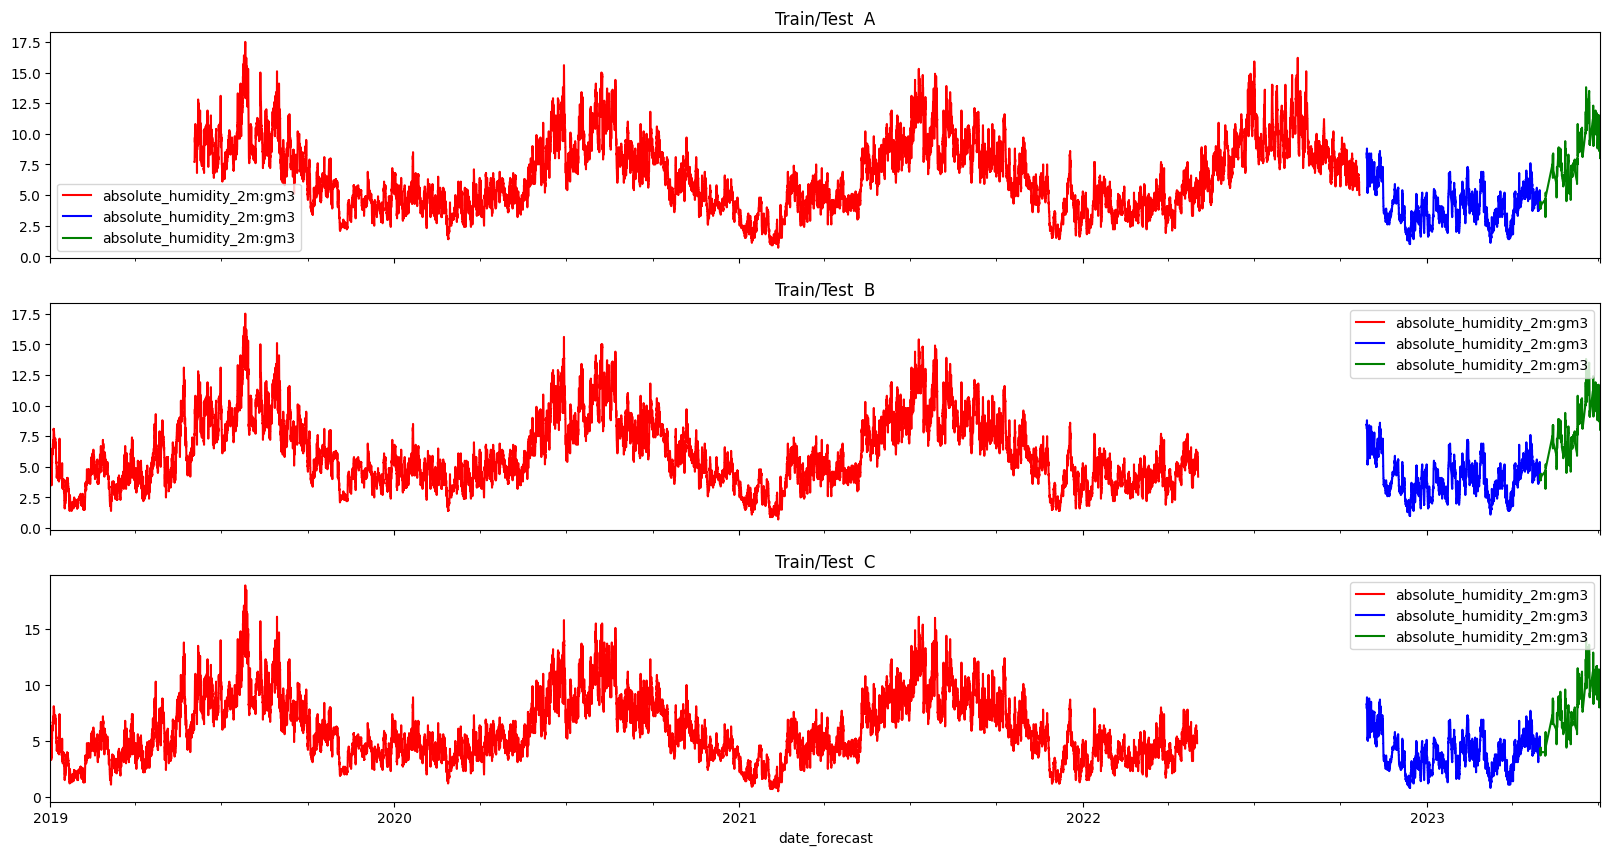

In [6]:
# Plotting a single feature
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = 'absolute_humidity_2m:gm3'
X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')

In [7]:
sets = [X_train_observed_a, X_train_estimated_a, X_test_estimated_a, X_train_observed_b, X_train_estimated_b, X_test_estimated_b, X_train_observed_c, X_train_estimated_c, X_test_estimated_c]

constant_columns = []
set_num=0
for set in sets:
    for column in set.columns:
        # Add constant
        if set[column].nunique() == 1 and set_num == 0:
            constant_columns.append(column)
        elif set[column].nunique() != 1 and column in constant_columns:
            # Pop impostor
            constant_columns.remove(column)
    set_num += 1


print(constant_columns)

['elevation:m']


In [40]:
train_a = pd.read_parquet(f'{starting_directory}/A/train_targets.parquet')
train_b = pd.read_parquet(f'{starting_directory}/B/train_targets.parquet')
train_c = pd.read_parquet(f'{starting_directory}/C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet(f'{starting_directory}/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet(f'{starting_directory}/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet(f'{starting_directory}/C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet(f'{starting_directory}/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet(f'{starting_directory}/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet(f'{starting_directory}/C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet(f'{starting_directory}/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet(f'{starting_directory}/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet(f'{starting_directory}/C/X_test_estimated.parquet')

In [41]:
# Pre-processing

# -> Perhaps problematic to set nan-values (especially) in target-dataset as zero, because this is likely not representative from the actual data(?)
def NanToZero(data):
    data1 = []
    for df in data:
        data1.append(df.fillna(0)) #replace Nan with 0.
    return data1


def quartersToHours(data):
    hourly_data = []
    for df in data:
        # Round the 'date_forecast' column to nearest hour
        df['date_forecast'] = df['date_forecast'].dt.round('H')

        # Group by 'date_forecast' and take the mean of each group
        # TODO Tror denne goofer litt
        df_hourly_mean = df.groupby('date_forecast').mean().reset_index()

        hourly_data.append(df_hourly_mean)

    return hourly_data

def convert_date_to_sin_and_cos(df):
    hour = 60*60
    day = 24*60*60
    year = (365.2425)*day
    month = year / 12.0
    
    df["year"] = [df["date_forecast"][i].year for i in range(len(df))]
    df["month"] = [df["date_forecast"][i].month for i in range(len(df))]
    df["hour"] = [df["date_forecast"][i].hour for i in range(len(df))]

    date_time = pd.to_datetime(df.pop('date_forecast'), format='%Y-%m.%d %H:%M:%S')
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    df['hour_sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
    df['hour_cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
    df['month_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    df['month_cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))


def appendLabels(train, val, labels):
    # Remove hour and minute values
    # val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    # train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    # Rename columns names to match
    #train = train.rename(columns={'date_forecast': 'date'})
    #val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date_forecast'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date_forecast")
    joined_val = pd.merge(val, labels, how="inner", on="date_forecast")

    
    return [joined_train, joined_val]


def dropDate(df, column, date):
    new_df = df
    for i in range(len(df)):
        if str(df.iloc[i][column])[0:10] == date:
            print('Dropping date', date)
            new_df = new_df.drop(index=df.iloc[i].name)
    
    return new_df

def findGap(X, y):
    for i in range(len(X)):
        X_date = X.iloc[i]['date']
        y_date = y.iloc[i]['time']
        if str(X_date) != str(y_date): 
            print(X_date)
            print(y_date)
            print("-------------------------------------")
            #X = dropDate(X, 'date_forecast', X_date)

# Sort data into month, day_of_week, hour
def sortDate(data):
    sorted_data = []
    for df in data:
        df["year"] = [df["date_forecast"][i].year for i in range(len(df))]
        df["month"] = [df["date_forecast"][i].month for i in range(len(df))]
        df["hour"] = [df["date_forecast"][i].hour for i in range(len(df))]
        sorted_data.append(df)
    return sorted_data


# Remove date columns
def removeNonNumeric(data):
    numeric_data = []
    for df in data:
        non_numeric_columns = df.select_dtypes(exclude='number').columns.tolist()
        df.drop(columns=non_numeric_columns, inplace=True)
        numeric_data.append(df)
    return numeric_data


def validNaming(data):
    # Replace : with -
    data1 = []
    for df in data:
        data1.append(df.rename(columns=lambda x: x.replace(':', '-')))
    return data1

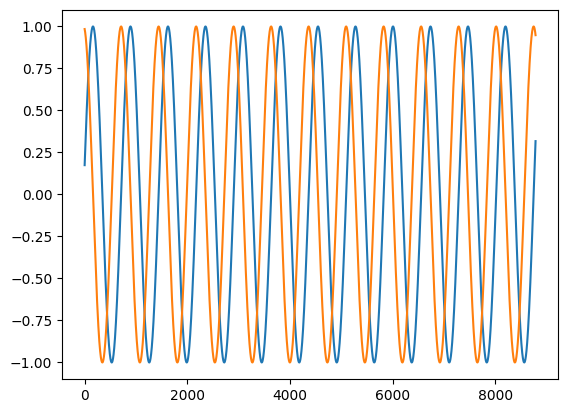

In [42]:
A = [X_train_observed_a, X_train_estimated_a]

A = quartersToHours(A)

A = appendLabels(A[0], A[1], train_a)

for X in A:
    convert_date_to_sin_and_cos(X)

plt.plot(A[0]['month_sin'][:366*24])
plt.plot(A[0]['month_cos'][:366*24])

#findGap(pd.concat([A[0], A[1]]), train_a)

A = NanToZero(A)
A = removeNonNumeric(A)

A = validNaming(A)

In [43]:
# Convert the dataset into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(A[0], label='pv_measurement', task=tfdf.keras.Task.REGRESSION)
print(A[1]['pv_measurement'].describe())
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(A[1], label='pv_measurement', task=tfdf.keras.Task.REGRESSION)

# Train a Random Forest model.
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model.fit(train_ds)

# Summary of the model structure.
#model.summary()

# Evaluate the model.
predictions = model.predict(test_ds)
print(predictions)
actual_values = A[1]['pv_measurement']

#A[1]['date_forecast'] = pd.to_datetime(A[1][['year_sin', 'month_sin', 'day_sin']])
#time_values = A[1]['date_forecast']

count    4395.000000
mean      339.703327
std       891.673372
min         0.000000
25%         0.000000
50%         0.000000
75%       124.520000
max      5172.640000
Name: pv_measurement, dtype: float64
Use /tmp/tmpornt6tmd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.790907. Found 29667 examples.
Training model...


[INFO 23-10-16 13:33:52.6654 UTC kernel.cc:1243] Loading model from path /tmp/tmpornt6tmd/model/ with prefix f537952c17134636
[INFO 23-10-16 13:33:58.5324 UTC decision_forest.cc:660] Model loaded with 300 root(s), 1238046 node(s), and 47 input feature(s).
[INFO 23-10-16 13:33:58.5325 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-10-16 13:33:58.5326 UTC kernel.cc:1075] Use fast generic engine


Model trained in 0:00:51.438186
Compiling model...
Model compiled.
5/5 [==============================] - 0s 49ms/step
[[0.00063231]
 [0.0006381 ]
 [0.00807355]
 ...
 [0.00166747]
 [0.00098832]
 [0.00066897]]


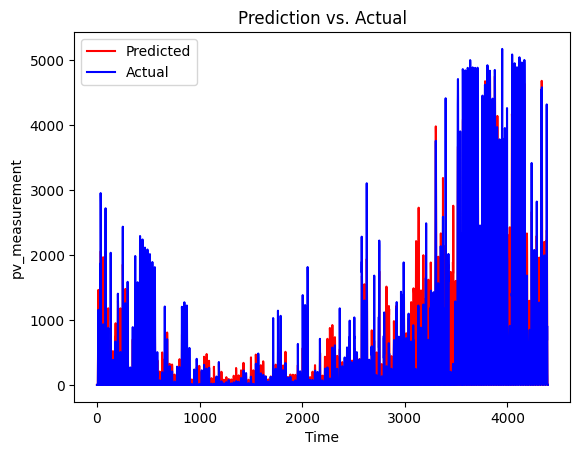

In [45]:
#print(mae(actual_values, predictions).numpy())

# Plotting Prediction vs. Actual
plt.plot(predictions, label='Predicted', color='red')
plt.plot(actual_values, label='Actual', color='blue')
plt.xlabel('Time')
plt.ylabel('pv_measurement')
plt.title('Prediction vs. Actual')
plt.legend()
plt.show()